# Lymphoid_No1_Colab_integration-with-HCA

## Mount Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Set up `scvi-tools` for CoLab use

In [ ]:
import sys

#if True, will install via pypi, else will install from source
stable = True
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB and stable:
    !pip install --quiet scvi-tools[tutorials]
elif IN_COLAB and not stable:
    !pip install --quiet --upgrade jsonschema
    !pip install --quiet git+https://github.com/yoseflab/scvi-tools@master#egg=scvi-tools[tutorials]

     |████████████████████████████████| 184kB 7.5MB/s eta 0:00:01
     |████████████████████████████████| 81kB 5.9MB/s 
     |████████████████████████████████| 245kB 11.5MB/s 
     |████████████████████████████████| 634kB 14.5MB/s 
     |████████████████████████████████| 204kB 26.3MB/s 
     |████████████████████████████████| 829kB 27.1MB/s 
     |████████████████████████████████| 122kB 36.4MB/s 
     |████████████████████████████████| 10.3MB 17.3MB/s 
     |████████████████████████████████| 3.1MB 58.4MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 2.4MB 54.7MB/s 
     |████████████████████████████████| 8.7MB 28.8MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 276kB 60.6MB/s 
     |████████████████████████████████| 829kB 44.6MB/s 
     |████████████████████████████████| 112kB 53.3MB/s 
     |████████████████████████████████| 112kB 55.0MB/s 
     |████████████████████████████████| 1.3

In [ ]:
!pip install SCCAF
!pip install scanpy --upgrade

     |████████████████████████████████| 2.2MB 11.5MB/s 
     |████████████████████████████████| 7.2MB 15.6MB/s 
  Found existing installation: scanpy 1.7.1
    Uninstalling scanpy-1.7.1:
      Successfully uninstalled scanpy-1.7.1
  Using cached https://files.pythonhosted.org/packages/c1/f4/a7848e6f990cf5bcbedade93702baf3e99ae704714563fe9bdceb3d597c7/scanpy-1.7.1-py3-none-any.whl
ERROR: sccaf 0.0.10 has requirement scanpy==1.4.6, but you'll have scanpy 1.7.1 which is incompatible.
  Found existing installation: scanpy 1.4.6
    Uninstalling scanpy-1.4.6:
      Successfully uninstalled scanpy-1.4.6


## Import required module

In [ ]:
import anndata
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import scvi

In [ ]:
sc.logging.print_header()
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.19.5 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.9.0 louvain==0.7.0 leidenalg==0.8.3


## Read in HCA raw data (from kk4)

* anndata was made in the anlysis kk4 as 'kk4_lymphoid-annotated_201230_raw.h5ad'

In [ ]:
HCA = sc.read_h5ad('/content/gdrive/My Drive/Colab/data/anndata/heart/Lymphocyte/HCA/HCA-Lymphoid_201230_raw.h5ad')
print(HCA.X.data[:10])
HCA

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


AnnData object with n_obs × n_vars = 17217 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'cell_states_ori', 'cell_states_new', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    obsm: 'X_pca', 'X_umap'

In [ ]:
HCA.obs['source'].cat.categories

Index(['CD45+', 'Cells', 'Nuclei'], dtype='object')

In [ ]:
# add Cells-Nuclei column
HCA.obs['Cells_Nuclei'] = HCA.obs['source']
HCA.obs.replace({'Cells_Nuclei': {
    'CD45+': 'Cells',
    'Cells': 'Cells',
    'Nuclei': 'Nuclei',
}}, inplace=True)
set(HCA.obs['Cells_Nuclei'])

{'Cells', 'Nuclei'}

In [ ]:
# extract Cell data
HCA = HCA[HCA.obs['Cells_Nuclei']=='Cells']
set(HCA.obs['Cells_Nuclei'])

{'Cells'}

In [ ]:
# remane coloumn name. donor to Patient
HCA.obs.rename(columns={'donor':'Patient'}, inplace=True)
# add 'HCA_'
HCA.obs['Patient'] = HCA.obs['Patient'].astype('str')
HCA.obs['Patient'] = 'HCA_' + HCA.obs['Patient']
HCA.obs['Patient'] = HCA.obs['Patient'].astype('category')

Trying to set attribute `.obs` of view, copying.


## Read in DCM raw data

In [ ]:
DCM = sc.read_h5ad('/content/gdrive/My Drive/Colab/data/anndata/heart/Lymphocyte/DCM_210305/Lymphoid_20210305_V1_RAW_doublet-removed.h5ad')
print(DCM.X.data[:10])
print(DCM.shape)
DCM

[1. 1. 2. 1. 3. 1. 1. 1. 1. 1.]
(16878, 33538)


AnnData object with n_obs × n_vars = 16878 × 33538
    obs: 'Patient', 'Sample', 'Gender', 'Gene', 'Diagnosis', 'Clinical.dominant.mutation', 'Age', 'Mutation.Type', 'Genomic.location', 'Region', 'Origin', 'n_genes', 'percent_mito', 'percent_ribo', 'X10X_version', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_z', 'predicted_doublets_z', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_20200602', 'cell_type_20200602', 'cell_type_20200921', 'cell_type_global_HCA', 'cell_states_HCA', 'cell_type_fine_20200921', 'cell_states_20200921', 'cell_states_long_20200921', 'cell_states_20210218', 'validated_20210218', 'leiden_01', 'leiden_02', 'leiden_03', 'leiden_04', 'cell_type', 'predicted_doublets_lymphoid_210305'
    var: 'gene_ids', 'feature_types', 'genome'

In [ ]:
# add Cells.Nuclei column
DCM.obs['Cells_Nuclei'] = 'Nuclei'

## Concatenate HCA and DCM data

In [ ]:
adata = HCA.concatenate(
    DCM,
    join='inner',
    batch_key='data',
    batch_categories=['HCA','DCM']
)
adata.obs['Patient'] = adata.obs['Patient'].astype('category')
adata.obs['Cells_Nuclei'] = adata.obs['Cells_Nuclei'].astype('category')
adata.obs['data'] = adata.obs['data'].astype('category')

In [ ]:
adata.obs['Patient'].cat.categories

Index(['BS_H15', 'BS_H20', 'BS_H25', 'BS_H26', 'BS_H35', 'BS_H37', 'D1', 'D2',
       'D4', 'D5', 'D6', 'D7', 'DL2', 'DL3', 'DO1', 'DP1', 'DP2', 'DS3', 'DT4',
       'H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10',
       'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20',
       'H21', 'H22', 'H24', 'H25', 'H26', 'H27', 'H28', 'H29', 'H31', 'H32',
       'H33', 'H34', 'H35', 'H36', 'H37', 'H39', 'H40', 'H41', 'H42', 'H44',
       'H46', 'H49', 'H51', 'H53', 'H55', 'H56', 'H57', 'H58', 'H59', 'H67',
       'H73', 'H78', 'H79', 'H80', 'H81', 'H84', 'HCA_D11', 'HCA_D3', 'HCA_D4',
       'HCA_D5', 'HCA_D6', 'HCA_D7', 'IC_H01', 'IC_H02', 'IC_H03', 'IC_H04'],
      dtype='object')

In [ ]:
adata.obs['Cells_Nuclei'].value_counts()

Nuclei    16878
Cells     10692
Name: Cells_Nuclei, dtype: int64

## Pre-process adata

In [ ]:
# Remove gene that are very lowly expressed
sc.pp.filter_genes(adata, min_counts=3)

# Normalized data are not used by scvi-tools, but given their popularity in other tasks as well as for visualization.
# -> store them in the anndata object separately (via the .raw attribute).
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# freeze the state in `.raw`
adata.raw = adata

filtered out 8404 genes that are detected in less than 3 counts
normalizing counts per cell
    finished (0:00:00)


In [ ]:
# batch key: Patient + Cells_Nuclei
adata.obs['Patient_CellNuc'] = [adata.obs['Patient'][i]+'_'+adata.obs['Cells_Nuclei'][i] for i in range(len(adata))]
adata.obs['Patient_CellNuc'] = adata.obs['Patient_CellNuc'].astype('category')
adata.obs['Patient_CellNuc'].cat.categories

Index(['BS_H15_Nuclei', 'BS_H20_Nuclei', 'BS_H25_Nuclei', 'BS_H26_Nuclei',
       'BS_H35_Nuclei', 'BS_H37_Nuclei', 'D1_Nuclei', 'D2_Nuclei', 'D4_Nuclei',
       'D5_Nuclei', 'D6_Nuclei', 'D7_Nuclei', 'DL2_Nuclei', 'DL3_Nuclei',
       'DO1_Nuclei', 'DP1_Nuclei', 'DP2_Nuclei', 'DS3_Nuclei', 'DT4_Nuclei',
       'H01_Nuclei', 'H02_Nuclei', 'H03_Nuclei', 'H04_Nuclei', 'H05_Nuclei',
       'H06_Nuclei', 'H07_Nuclei', 'H08_Nuclei', 'H09_Nuclei', 'H10_Nuclei',
       'H11_Nuclei', 'H12_Nuclei', 'H13_Nuclei', 'H14_Nuclei', 'H15_Nuclei',
       'H16_Nuclei', 'H17_Nuclei', 'H18_Nuclei', 'H19_Nuclei', 'H20_Nuclei',
       'H21_Nuclei', 'H22_Nuclei', 'H24_Nuclei', 'H25_Nuclei', 'H26_Nuclei',
       'H27_Nuclei', 'H28_Nuclei', 'H29_Nuclei', 'H31_Nuclei', 'H32_Nuclei',
       'H33_Nuclei', 'H34_Nuclei', 'H35_Nuclei', 'H36_Nuclei', 'H37_Nuclei',
       'H39_Nuclei', 'H40_Nuclei', 'H41_Nuclei', 'H42_Nuclei', 'H44_Nuclei',
       'H46_Nuclei', 'H49_Nuclei', 'H51_Nuclei', 'H53_Nuclei', 'H55_Nuclei',
 

In [ ]:
adata.X.data[:10]

array([2.0061994, 2.0061994, 2.0061994, 2.0061994, 2.0061994, 2.0061994,
       2.0061994, 2.0061994, 2.0061994, 2.0061994], dtype=float32)

In [ ]:
# Feature selection
# subset = True
sc.pp.highly_variable_genes(
    adata,
    subset=True,
    # layer="counts",
    batch_key="Patient_CellNuc",
    flavor="seurat",
    n_top_genes=1000,
)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, batch_key='batch_key')
sc.pl.highly_variable_genes(adata)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
    finished (0:00:19)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## Setup anndata for scVI

In [ ]:
scvi.data.setup_anndata(adata, layer="counts", batch_key="Patient_CellNuc")

INFO     Using batches from adata.obs["Patient_CellNuc"]                                     
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 27570 cells, 1000 vars, 85        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


## Creating and training a model

In [ ]:
vae = scvi.model.SCVI(adata, n_hidden = 128, n_latent = 50, n_layers = 3, dispersion = 'gene-batch')
vae

In [ ]:
scvi.data.view_anndata_setup(adata)

In [ ]:
vae.train()

GPU available: True, used: True
TPU available: None, using: 0 TPU cores


Epoch 290/290: 100%|██████████| 290/290 [10:26<00:00,  2.16s/it, loss=232, v_num=1]


In [ ]:
# Save scvi model
vae.save("/content/gdrive/My Drive/Colab/data/models/scvi_model/vae_kk14_lymphocyte_210311_hvg1000/")

In [ ]:
adata.obsm["X_scVI"] = vae.get_latent_representation()

In [ ]:
adata.write('/content/gdrive/My Drive/Colab/data/anndata/heart/Lymphocyte/DCM_210305/Lymohoid_HCA-DCM-scVI_210311.h5ad')

In [ ]:
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors = 30, metric = 'minkowski')
sc.tl.leiden(adata, resolution=1.3, key_added="leiden_scVI")
sc.tl.umap(adata, min_dist = 0.5, spread = 3, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:35)


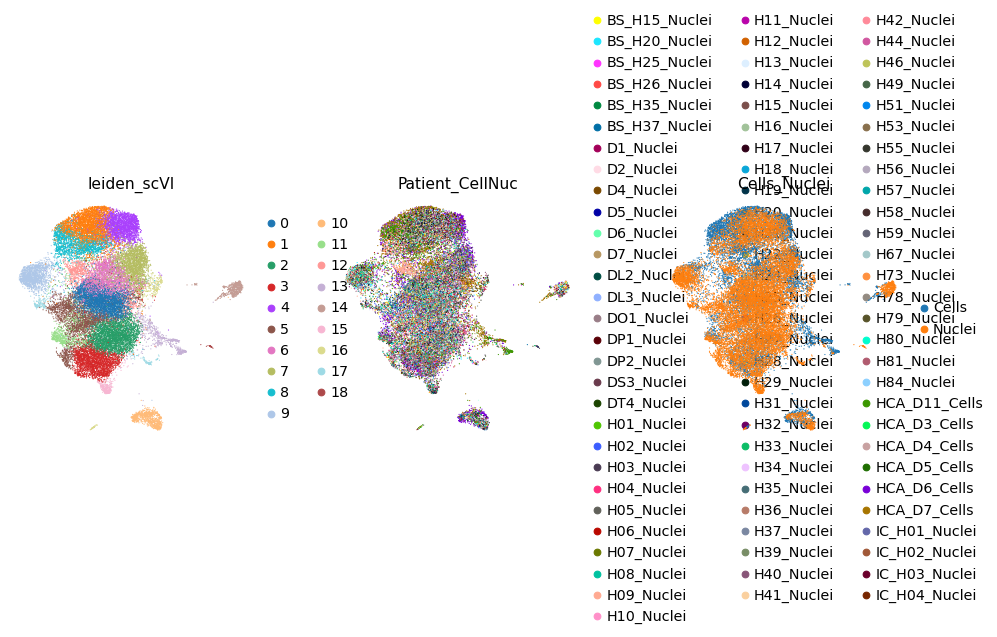

In [ ]:
sc.pl.umap(
    adata,
    color=['leiden_scVI','Patient_CellNuc','Cells_Nuclei'],
    frameon=False,
    # legend_loc='on data'
)

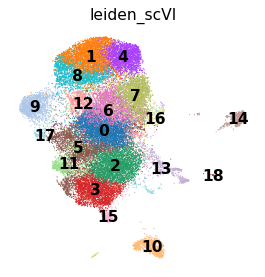

In [ ]:
sc.pl.umap(
    adata,
    color=['leiden_scVI'],
    frameon=False,
    legend_loc='on data'
)

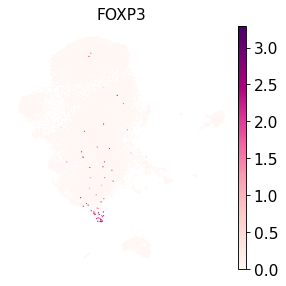

In [ ]:
sc.pl.umap(
    adata,
    color=['FOXP3'],
    frameon=False,
    cmap='RdPu'
    # legend_loc='on data'
)

In [ ]:
Treg = adata[adata.obs['leiden_scVI']=='10']
Treg.obs.data.value_counts()

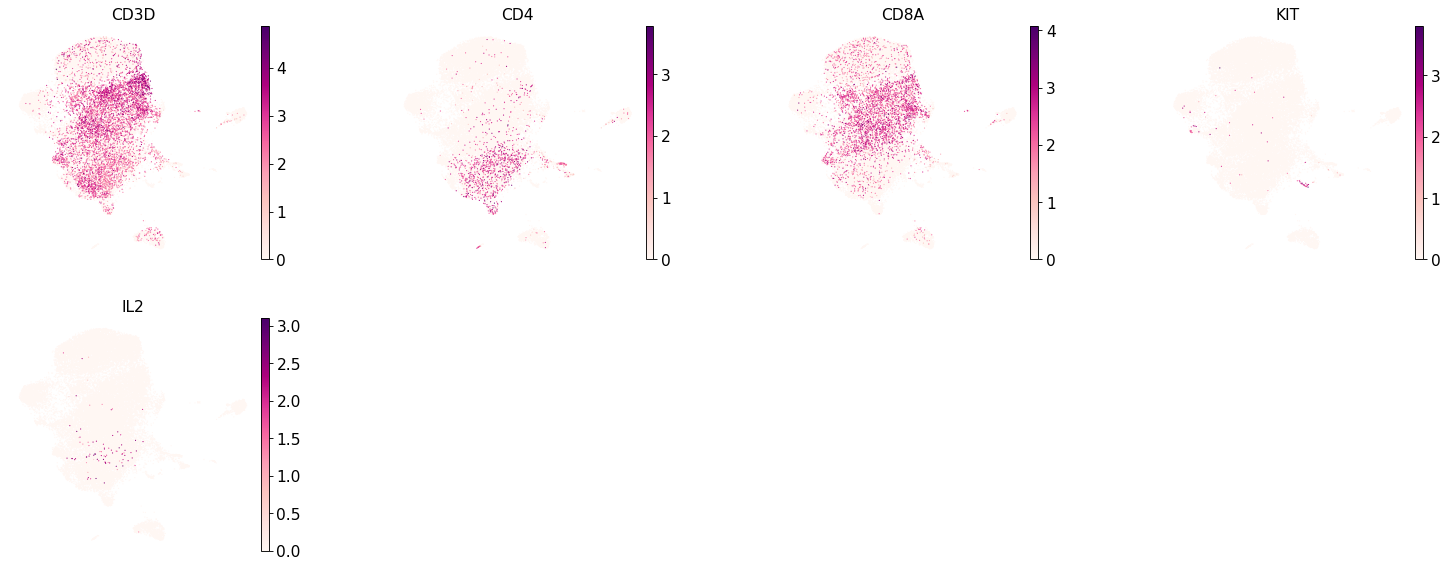

In [ ]:
sc.pl.umap(
    adata,
    color=['CD3D','CD4','CD8A','KIT','IL2'],
    frameon=False,
    # legend_loc='on data'
    cmap='RdPu',
    wspace=0.4
)

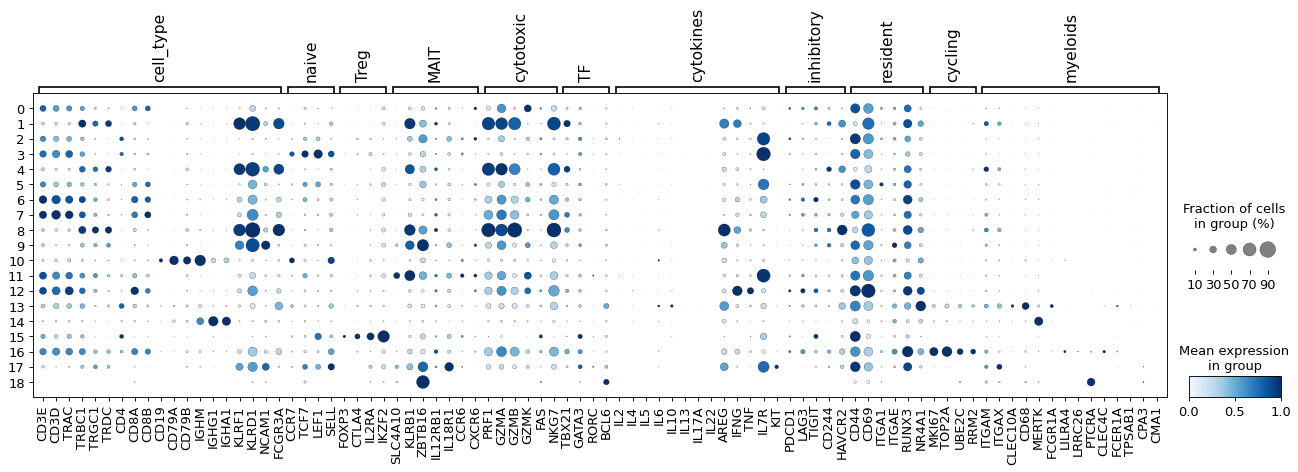

In [ ]:
# adata = adata.raw.to_adata()

# markers genes
markers_df = pd.read_csv('/content/gdrive/My Drive/Colab/data/csv/genesets/marker-genes_210223.csv')

# remove categories
# markers_df = markers_df[markers_df['category']!='myeloids']

# remove genes, which are not in the dataset
for i in range(len(markers_df)):
    genes = markers_df.genes[i].split(',')
    pos = [x in adata.var_names for x in genes]
    genes = [genes[x] for x in np.where(pos)[0]]
    markers_df.genes[i] = ','.join(genes).split(',')
    
# convert to dictionary
markers_dict = markers_df.set_index('category').T.to_dict('list')

for key in markers_dict.keys():
    markers_dict[key] = list(np.array(markers_dict[key])[0])

# plot
# sc.tl.dendrogram(adata, groupby='leiden_scVI')
sc.pl.dotplot(
    adata,
    markers_dict,
    groupby='leiden_scVI',
    dendrogram=False,
    # categories_order = lymphocytes_order,
    color_map="Blues",
    standard_scale="var", 
    figsize=[20, 5],
)

In [ ]:
adata.obs['cell_states_kk14'] = adata.obs['leiden_scVI']
adata.obs['cell_states_kk14'] = adata.obs['cell_states_kk14'].astype('str')
adata.obs.replace({'cell_states_kk14': {
    '0': 'NK_CD16hi',
    '1': 'CD8+T_trans',
    '2': 'CD4+T_act',
    '3': 'CD4+T_naive',
    '4': 'CD8+T_cytox',
    '5': 'CD8+T_te',
    '6': 'CD8+T_em',
    '7': 'NK_CD56hi',
    '8': 'unclassfied.1',
    '9': 'B',
    '10': 'Cycling',
    '11': 'MAIT-like',
    '12': 'B_plasma',
    '13': 'CD4+T_reg',
    '14': 'ILC',
    '15': 'unclassfied.2',
}}, inplace=True)
adata.obs['cell_states_kk14'] = adata.obs['cell_states_kk14'].astype('category')

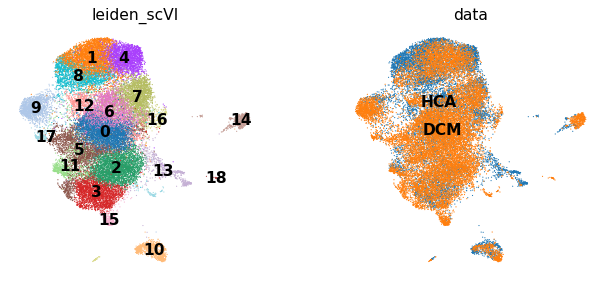

In [ ]:
sc.pl.umap(adata,color=['leiden_scVI', 'data'], frameon=False, legend_loc='on data')

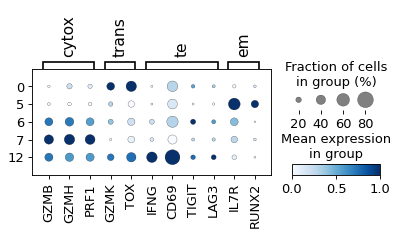

In [ ]:
CD8T = adata[adata.obs['leiden_scVI'].isin(['0','5','6','7','12'])]

markers_dict = {
    'cytox': ['GZMB', 'GZMH', 'PRF1'],
    'trans': ['GZMK','TOX'],
    'te': ['IFNG', 'CD69', 'TIGIT', 'LAG3'],
    'em': ['IL7R','RUNX2'],
}

sc.pl.dotplot(
    CD8T,
    markers_dict,
    groupby="leiden_scVI",
    color_map="Blues",
    standard_scale="var",
)

In [ ]:
sc.pl.umap(adata,color=['data'],frameon=False)

In [ ]:
# markers genes
markers_df = pd.read_csv('/content/gdrive/My Drive/Colab/data/csv/genesets/marker-genes_210223.csv')

# remove categories
markers_df = markers_df[markers_df['category']!='myeloids']

# remove genes, which are not in the dataset
for i in range(len(markers_df)):
    genes = markers_df.genes[i].split(',')
    pos = [x in adata.var_names for x in genes]
    genes = [genes[x] for x in np.where(pos)[0]]
    markers_df.genes[i] = ','.join(genes).split(',')
    
# convert to dictionary
markers_dict = markers_df.set_index('category').T.to_dict('list')

for key in markers_dict.keys():
    markers_dict[key] = list(np.array(markers_dict[key])[0])

# plot
sc.pl.dotplot(
    adata,
    markers_dict,
    groupby='cell_states_kk14',
    dendrogram=False,
    # categories_order = lymphocytes_order,
    color_map="Blues",
    standard_scale="var",
    figsize=[20, 5]
)

In [ ]:
DCM_post = adata[adata.obs['data']=='DCM']
sc.pl.umap(DCM_post,color=['cell_states_kk14'], frameon=False)